In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,cross_val_score
import optuna
import numpy as np

In [2]:
# Abrimos la data tanto de entrenamiento como de test
df = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/train.csv')
df_test_public = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_public.csv')
df_test_private = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_private.csv')

### Exploratory Data Analysis (EDA)

In [3]:
nulos_en_data = df.isna().sum(axis=0)
nulos_en_data_ordenados = nulos_en_data[nulos_en_data>0].sort_values()

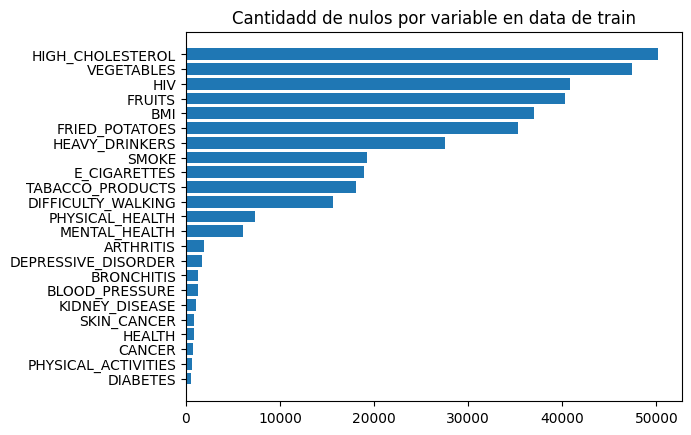

In [4]:
fig, ax = plt.subplots(1, 1)  
ax.barh(y=nulos_en_data_ordenados.index,width = nulos_en_data_ordenados)
ax.set_title('Cantidadd de nulos por variable en data de train')
plt.show()

Incialmente se decidió emplear modelos de boosting como XGBoost, Catboost y LGBM. Estos modelos de boosting no requieren que imputemos ni reescalemos los valores. Dado que el algoritmo encuentra por "donde deben ir" los valores nulos en los árboles de decisión para reducir la función de costo.

In [5]:
conteos_clase = df['CHD_OR_MI'].value_counts()

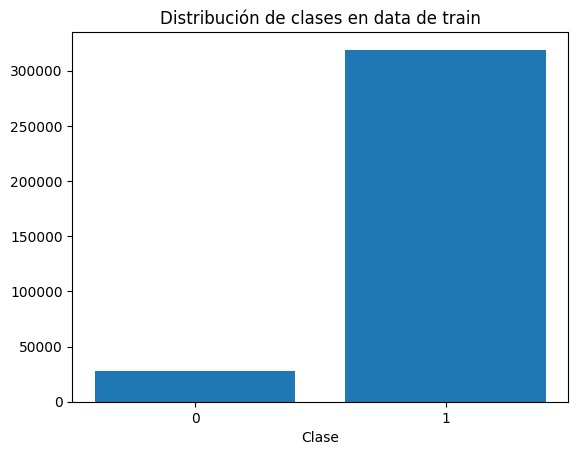

In [6]:
fig, ax = plt.subplots(1, 1)  
ax.bar(x=conteos_clase.index,height = conteos_clase)
ax.set_title('Distribución de clases en data de train')
ax.set_xticks([0,1])
ax.set_xlabel('Clase')
plt.show()

Vemos que hay un desbalance de clases. Más adelante se intento
* Utilizar el párametro de los clasificadores scale_pos_weight para ajustar el peso de las clases
* Aplicar la técnica de oversampling SMOTE (Synthetic Minority Oversampling Technique Edited Nearest Neighbours). Esta segunda técnica si requiere una imputación de valores. Se dará mayor detalle de la imputación posteriormente

Antes de analizar la correlación, graficamos los histogramas de cada variables sea categorica o númerica

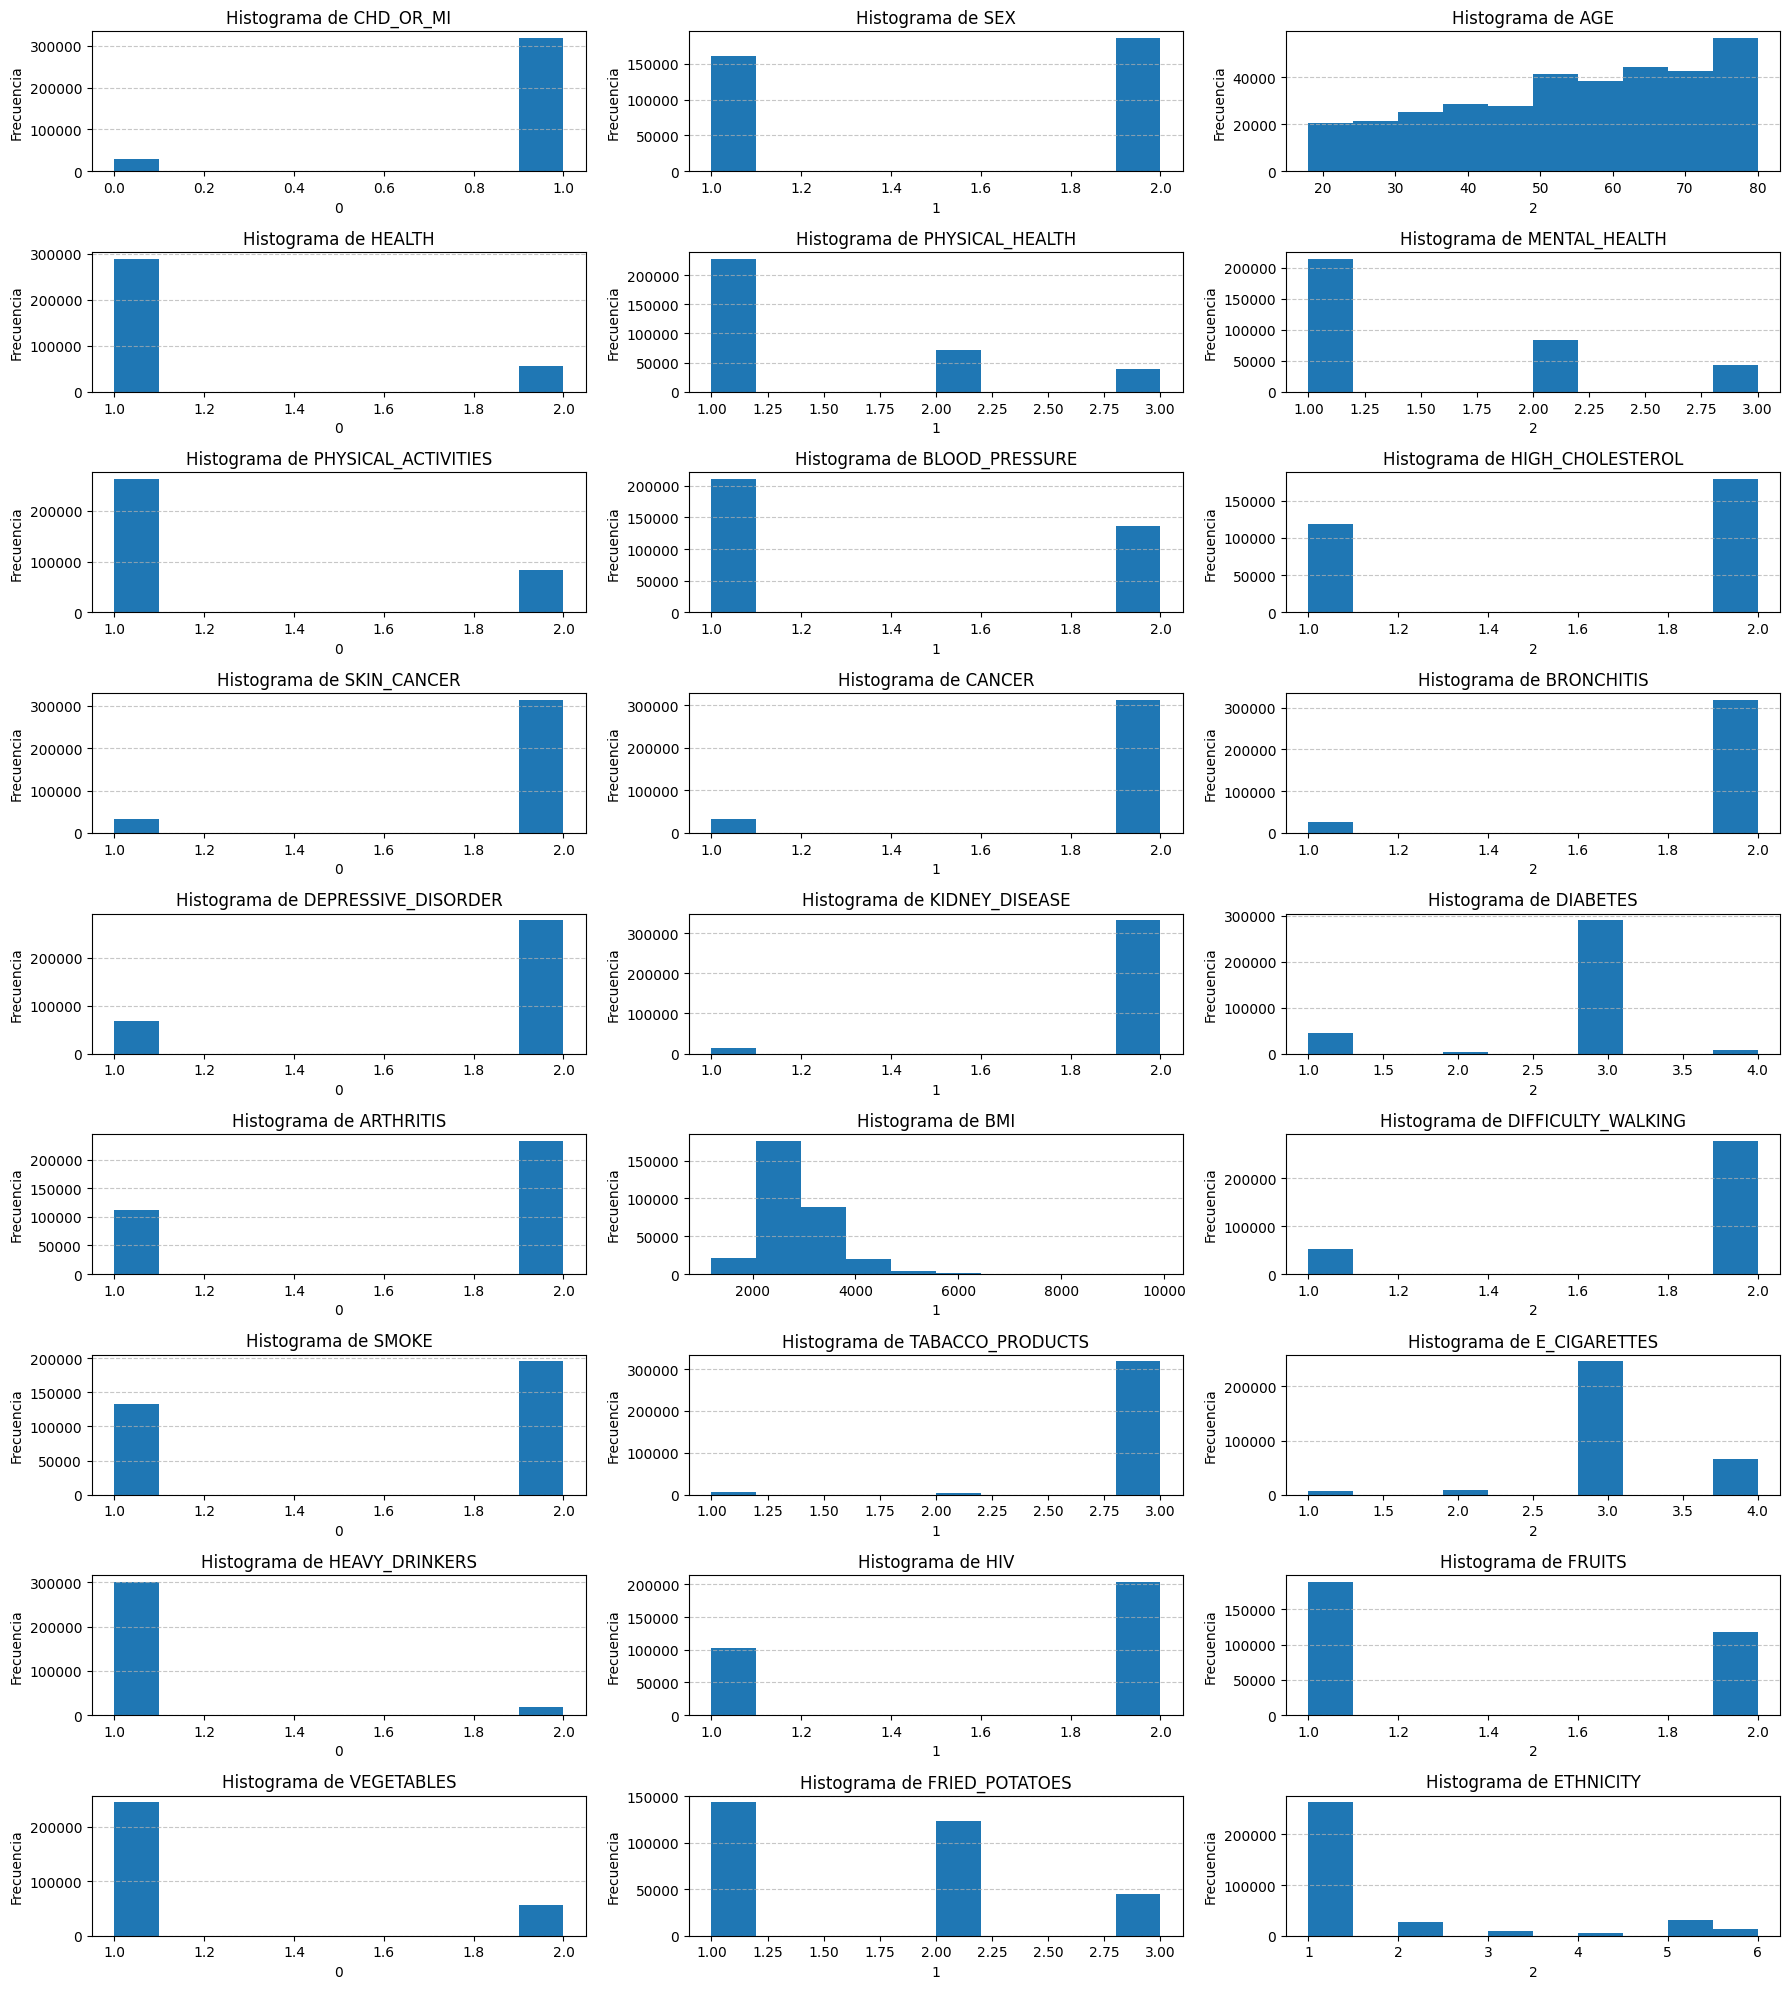

In [7]:
fig,ax = plt.subplots(9,3,figsize=(18,20),layout='tight') # Son 27 columnas excluyend el ID (9*3)
for i,columna in enumerate(df.columns):
    if columna!='ID':
        fil = i // 3  
        col = i % 3  
        ax[fil, col].hist(df[columna])
        ax[fil, col].set_title(f'Histograma de {columna}')
        ax[fil, col].set_xlabel(col)
        ax[fil, col].set_ylabel('Frecuencia')
        ax[fil, col].grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La mayor parte de las variables son categoricas. Solo dos son númericas BMI y Edad. Por esta razón no se calculó la correlación. 

Después de observar la distribución de las variables categoricas se optó por imputar valores utilizando la moda. No se imputo utilizando la media porque la mayor parte de las variables no son númericas (son representadas como número) y la media tendrá un resultado decimal que no representará a ninguna de las etiquetas.

### Probando modelos de boosting

Como intento inicial se deció probar con 3 modelos de boosting: catboost, lightgmb y xgboost.

In [8]:
X,y = df.drop(['CHD_OR_MI','ID'],axis=1),df[['CHD_OR_MI']] 
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

In [9]:
def measure_performate_model_on_test(modelo,x_train,y_train,x_test,y_test):
    modelo.fit(x_train,y_train)
    y_pred = modelo.predict(x_test)
    print(classification_report(y_test,y_pred))
    print('F1 score')
    print(f1_score(y_test,y_pred))

In [10]:
# Probamos los 3 modelos con los hiperparametros determinadas
catboost_model = CatBoostClassifier(
    scale_pos_weight=1, # 1
    random_state=42,
    verbose=False)

xgboost_model = XGBClassifier(
    scale_pos_weight=1, 
    random_state=42,
    )  

lightgbm_model = LGBMClassifier(
    scale_pos_weight=1,   
    random_state=42,
    verbose=0)

In [11]:
print('Resultados del catboost con hiperparametros default')
measure_performate_model_on_test(catboost_model,x_train,y_train,x_val,y_val)
print('Resultados del xgboost con hiperparametros default')
measure_performate_model_on_test(xgboost_model,x_train,y_train,x_val,y_val)
print('Resultados del light_gbm con hiperparametros')
measure_performate_model_on_test(lightgbm_model,x_train,y_train,x_val,y_val)

Resultados del catboost con hiperparametros default
              precision    recall  f1-score   support

         0.0       0.52      0.08      0.15      5671
         1.0       0.92      0.99      0.96     63779

    accuracy                           0.92     69450
   macro avg       0.72      0.54      0.55     69450
weighted avg       0.89      0.92      0.89     69450

F1 score
0.9573702589530014
Resultados del xgboost con hiperparametros default
              precision    recall  f1-score   support

         0.0       0.53      0.10      0.16      5671
         1.0       0.93      0.99      0.96     63779

    accuracy                           0.92     69450
   macro avg       0.73      0.54      0.56     69450
weighted avg       0.89      0.92      0.89     69450

F1 score
0.9575557690416575
Resultados del light_gbm con hiperparametros


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

         0.0       0.57      0.07      0.13      5671
         1.0       0.92      1.00      0.96     63779

    accuracy                           0.92     69450
   macro avg       0.75      0.53      0.54     69450
weighted avg       0.89      0.92      0.89     69450

F1 score
0.9579739346328284


Los tres modelos obtuvieron un resultado similar. La precisión y el recall para cada clase nos permite ver que el modelo tiene un muy buen desempeño en las clase positiva pero uno deficiente para la clase negativa. Es por ello que se procedió a utilizar el SMOTE para generar nuevas observaciones.

### Uso de la técnica SMOTE

SMOTE no trabaja con valores nulos. Por ello se probó con el simple imputer para completar los valores nulos utilizando la moda.

In [12]:
def fit_transform_imputer(imputer,x_train,x_test):
    x_train_imputed = imputer.fit_transform(x_train)
    x_test_imputed = imputer.transform(x_test)
    return x_train_imputed,x_test_imputed

In [13]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer

iterativ_imputer = SimpleImputer(strategy='most_frequent') #usamos la moda porque la mayor parte de las variables son categoricas
x_train_itev,x_val_itev = fit_transform_imputer(iterativ_imputer,x_train,x_val)

In [14]:
smote = SMOTE(
    sampling_strategy = 0.7,
    k_neighbors=3,
    n_jobs=-1,
)
catboost_model = CatBoostClassifier(
    scale_pos_weight=1, 
    random_state=42,
    verbose=False)
xgboost_model = XGBClassifier(
    scale_pos_weight=1, 
    random_state=42,
    )  
lightgbm_model = LGBMClassifier(
    scale_pos_weight=1,
    random_state=42,
    verbose=0)
x_smo,y_smo = smote.fit_resample(x_train_itev,y_train)

/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [15]:
print('Resultados del catboost con hiperparametros default y SMOTE + Simple Imputer')
measure_performate_model_on_test(catboost_model,x_smo,y_smo,x_val,y_val) 
print('Resultados del xgboost con hiperparametros default y SMOTE + Simple Imputer')
measure_performate_model_on_test(xgboost_model,x_smo,y_smo,x_val,y_val)
print('Resultados del light_gbm con hiperparametros default y SMOTE + Simple Imputer')
measure_performate_model_on_test(lightgbm_model,x_smo,y_smo,x_val,y_val)

Resultados del catboost con hiperparametros default y SMOTE + Simple Imputer
              precision    recall  f1-score   support

         0.0       0.47      0.11      0.17      5671
         1.0       0.93      0.99      0.96     63779

    accuracy                           0.92     69450
   macro avg       0.70      0.55      0.57     69450
weighted avg       0.89      0.92      0.89     69450

F1 score
0.9565296471444161
Resultados del xgboost con hiperparametros default y SMOTE + Simple Imputer
              precision    recall  f1-score   support

         0.0       0.52      0.08      0.14      5671
         1.0       0.92      0.99      0.96     63779

    accuracy                           0.92     69450
   macro avg       0.72      0.54      0.55     69450
weighted avg       0.89      0.92      0.89     69450

F1 score
0.9574243065208196
Resultados del light_gbm con hiperparametros default y SMOTE + Simple Imputer


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

         0.0       0.53      0.09      0.16      5671
         1.0       0.92      0.99      0.96     63779

    accuracy                           0.92     69450
   macro avg       0.73      0.54      0.56     69450
weighted avg       0.89      0.92      0.89     69450

F1 score
0.9576257088846881


Hasta este punto no hay diferencias significativas en el rendimiento de los modelos se procedio a modificar algunos hiperparámetros.Crear muestras sintéticas con SMOTE tampoco mejoró el desempeño de los modelos. Se procedió a optimizar los hiperparametros utilizando la librería optuna.

### Optimización de hiperparámetros de los modelos de boosting

In [16]:
X,y = df.drop(['CHD_OR_MI','ID'],axis=1),df[['CHD_OR_MI']] # Borramos el ID y la clase para evitar data leaking
X_test,y_test = df_test_public.drop(['CHD_OR_MI','ID'],axis=1),df_test_public[['CHD_OR_MI']]

X,y = X.to_numpy(), y.to_numpy().reshape(-1)
X_test,y_test = X_test.to_numpy(), y_test.to_numpy().reshape(-1)

In [17]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10, log=True),
        'verbose': -1  
    }

    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_val)[:, 1]

        y_pred = (y_prob >= threshold).astype(int)

        score = f1_score(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)
    

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50)             


print("Hiperparámetros del mejor modelo:", study.best_params)
print("F1-score del mejor modelo:", study.best_value)

best_params = study.best_params
best_params['objective'] = 'binary'
best_model_lgb = LGBMClassifier(**best_params, verbose=-1)

best_model_lgb.fit(X, y)

y_pred = best_model_lgb.predict(X_test)
print("F1-score en el conjunto de test:", f1_score(y_test, y_pred, average='binary'))

[I 2024-12-22 04:35:11,790] A new study created in memory with name: no-name-1c5dea2c-facb-4bfd-8a2b-8ac35d1d93e8
[I 2024-12-22 04:35:51,929] Trial 0 finished with value: 0.9531515772411966 and parameters: {'learning_rate': 0.13699692729615437, 'num_leaves': 102, 'max_depth': 7, 'n_estimators': 263, 'min_child_weight': 4.321727637399888, 'subsample': 0.5001710212850421, 'colsample_bytree': 0.6400946745494998, 'lambda_l1': 0.5235577465813082, 'lambda_l2': 0.001260262983867049, 'threshold': 0.6394123265959235}. Best is trial 0 with value: 0.9531515772411966.
[I 2024-12-22 04:36:15,134] Trial 1 finished with value: 0.957993899288821 and parameters: {'learning_rate': 0.1314245341739302, 'num_leaves': 87, 'max_depth': 3, 'n_estimators': 238, 'min_child_weight': 0.2437646825617296, 'subsample': 0.7918858523657777, 'colsample_bytree': 0.6690431041306079, 'lambda_l1': 0.007716096804457198, 'lambda_l2': 9.097978849352973, 'threshold': 0.42434191262758647}. Best is trial 1 with value: 0.95799389

Hiperparámetros del mejor modelo: {'learning_rate': 0.022332874541078015, 'num_leaves': 132, 'max_depth': 5, 'n_estimators': 158, 'min_child_weight': 4.866280143363872, 'subsample': 0.9474844687939509, 'colsample_bytree': 0.5152723515633579, 'lambda_l1': 1.9751499736006153, 'lambda_l2': 0.0067801307784704085, 'threshold': 0.5125885258480708}
F1-score del mejor modelo: 0.9581139433832244
F1-score en el conjunto de test: 0.9580854190253656


In [18]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',  
        'eval_metric': 'logloss',       
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),  
        'alpha': trial.suggest_float('alpha', 1e-3, 10, log=True)    
    }

    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = XGBClassifier(**params, use_label_encoder=False, verbosity=0)
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_val)[:, 1]

        y_pred = (y_prob >= threshold).astype(int)

        score = f1_score(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)


study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50)             

print("Hiperparámetros del mejor modelo:", study.best_params)
print("F1-score del mejor modelo:", study.best_value)

best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_model_xgb = XGBClassifier(**best_params, use_label_encoder=False, verbosity=0)
best_model_xgb.fit(X, y)

y_pred = best_model_xgb.predict(X_test)
print("F1-score en el conjunto de prueba:", f1_score(y_test, y_pred))


[I 2024-12-22 04:59:35,538] A new study created in memory with name: no-name-2a162875-7c63-4c95-8e3a-8fa2fb019def
[I 2024-12-22 05:00:43,685] Trial 0 finished with value: 0.9547802657277747 and parameters: {'learning_rate': 0.0486963280800317, 'max_depth': 11, 'n_estimators': 239, 'min_child_weight': 0.023804903547008996, 'subsample': 0.9378825324688055, 'colsample_bytree': 0.7100827934346873, 'lambda': 0.008369605857388078, 'alpha': 1.1697470425435295, 'threshold': 0.6175624416224961}. Best is trial 0 with value: 0.9547802657277747.
[I 2024-12-22 05:01:00,414] Trial 1 finished with value: 0.9499025156095433 and parameters: {'learning_rate': 0.036531147301853785, 'max_depth': 4, 'n_estimators': 155, 'min_child_weight': 0.5330926808899606, 'subsample': 0.8138701093273051, 'colsample_bytree': 0.5385242975288054, 'lambda': 6.34423238813891, 'alpha': 0.6079350597995224, 'threshold': 0.7124175182295053}. Best is trial 0 with value: 0.9547802657277747.
[I 2024-12-22 05:01:15,564] Trial 2 fin

Hiperparámetros del mejor modelo: {'learning_rate': 0.2932757988315497, 'max_depth': 3, 'n_estimators': 116, 'min_child_weight': 0.30394511103246197, 'subsample': 0.6522550550722543, 'colsample_bytree': 0.7993712040947701, 'lambda': 0.004566982964251, 'alpha': 0.03381833492700065, 'threshold': 0.4590010586887075}
F1-score del mejor modelo: 0.9580430796274219
F1-score en el conjunto de prueba: 0.9577774555297758


### Predicciones con el mejor modelo de boosting y con los mejores hiperpárametros

In [19]:
best_model = LGBMClassifier(
    learning_rate = 0.016656089841187875,
    num_leaves= 104, 
    max_depth= 7,
    n_estimators= 193,
    min_child_weight= 0.01267329030708188,
    subsample= 0.9502480575387506,
    colsample_bytree= 0.5835056585030413,
    lambda_l1= 1.8445416437113022,
    lambda_l2= 0.002454292172324635,
    verbose=-1)
best_model.fit(X, y)

y_pred = best_model.predict(X_test)
print("F1-score en el conjunto de prueba:", f1_score(y_test, y_pred, average='binary'))

predict_from = pd.concat([df_test_public.drop(['ID','CHD_OR_MI'],axis=1),df_test_private.drop('ID',axis=1)])
final_predictions = best_model.predict(predict_from)

df = pd.DataFrame(list(dict(zip(pd.concat([df_test_public['ID'],df_test_private['ID']]),final_predictions)).items()), columns=['ID', 'CHD_OR_MI'])
df.to_csv('resultados.csv',index=False) # Aqui guardamos las preddiciones finales este es el archivo que subí

F1-score en el conjunto de prueba: 0.9581641871950853
